# 🧠 Train a neural network with finite difference

backprop training
Epoch 1000 loss 2.005e-02
Epoch 2000 loss 1.237e-02
Epoch 3000 loss 4.084e-03
Epoch 4000 loss 7.694e-04
Epoch 5000 loss 5.541e-04
Epoch 6000 loss 4.421e-04
Epoch 7000 loss 2.853e-04
Epoch 8000 loss 1.073e-04
Epoch 9000 loss 4.786e-05
Epoch 10000 loss 3.234e-05

finitediff training
Epoch 1000 loss 4.526e-03
Epoch 2000 loss 3.099e-04
Epoch 3000 loss 1.371e-04
Epoch 4000 loss 1.101e-04
Epoch 5000 loss 8.663e-05
Epoch 6000 loss 6.338e-05
Epoch 7000 loss 4.355e-05
Epoch 8000 loss 2.894e-05
Epoch 9000 loss 1.945e-05
Epoch 10000 loss 1.388e-05


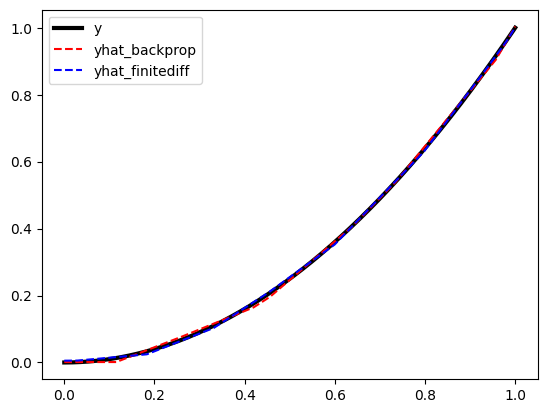

In [2]:
import jax
import jax.numpy as jnp
import finitediffx as fdx
import matplotlib.pyplot as plt

x = jnp.linspace(0, 1, 1_000)[:, None]
y = x**2

params = {
    "w1": jax.random.uniform(jax.random.PRNGKey(0), shape=[1, 20]),
    "b1": jnp.zeros([20]),
    "w2": jax.random.uniform(jax.random.PRNGKey(0), shape=[20, 1]),
    "b2": jnp.zeros([1]),
}


def forward(params: dict[str, jax.Array], x: jax.Array):
    x = x @ params["w1"] + params["b1"]
    x = jax.nn.relu(x)
    x = x @ params["w2"] + params["b2"]
    return x


def loss_func(params: dict[str, jax.Array], x: jax.Array, y: jax.Array):
    ypred = forward(params, x)
    return jnp.mean((ypred - y) ** 2)


@jax.jit
def backprop_train_step(
    params: dict[str, jax.Array],
    x: jax.Array,
    y: jax.Array,
    lr: float,
):
    loss, grads = jax.value_and_grad(loss_func)(params, x, y)
    params = {k: v - lr * grads[k] for k, v in params.items()}
    return params, loss


@jax.jit
def forward_train_step(
    params: dict[str, jax.Array],
    x: jax.Array,
    y: jax.Array,
    lr: float,
):
    loss, grads = fdx.value_and_fgrad(loss_func)(params, x, y)
    params = {k: v - lr * grads[k] for k, v in params.items()}
    return params, loss


def train(
    params: dict[str, jax.Array],
    x: jax.Array,
    y: jax.Array,
    lr: float,
    epochs: int,
    fd_grad: bool = False,
):
    train_step = forward_train_step if fd_grad else backprop_train_step

    for epoch in range(1, epochs + 1):
        params, loss = train_step(params, x, y, lr)
        if epoch % 1_000 == 0:
            print(f"Epoch {epoch} loss {loss:.3e}")
    return params


print("backprop training")
params_backprop = train(params, x, y, lr=1e-2, epochs=10_000, fd_grad=False)

print("\nfinitediff training")
params_forward = train(params, x, y, lr=1e-2, epochs=10_000, fd_grad=True)

yhat_backprop = forward(params_backprop, x)
yhat_forward = forward(params_forward, x)

plt.plot(x, y, "-k", label="y", linewidth=3)
plt.plot(x, yhat_backprop, "--r", label="yhat_backprop")
plt.plot(x, yhat_forward, "--b", label="yhat_finitediff")
plt.legend()